# Stockprice Prediction using RNN


The objective of our project is to develop and implement a recurrent neural network (RNN) for the precise prediction of future stock market movements. The aim is to identify patterns and trends in historical price data that can be used to inform future price predictions.

## Related work 

#### Stock Prediction RNN

This project employs Python and Keras to implement a LSTM-based model for forecasting stock prices. It utilises yfinance data for training and provides a detailed guide on utilising LSTM in RNNs for financial forecasting. https://github.com/Livisha-K/stock-prediction-rnn

#### Stock Price Prediction Using Yfinance, LSTM, and RNN

This project describes an approach to improved stock price forecasting using LSTM and RNN models. It provides insights into the application of deep learning in financial forecasting and utilises historical stock price data sourced via the yfinance API. https://github.com/AjNavneet/StockPricePrediction_YFinance_LSTM_RNN

## Data processing

In [45]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [46]:
#meta_data = pd.read_csv('C:/Daten/Neural_Networks/stock_prediction/symbols_valid_meta.csv')
meta_data = pd.read_csv('symbols_valid_meta.csv')
print(meta_data.head())
print(meta_data.columns)
print(meta_data.shape)

  Nasdaq Traded Symbol                                      Security Name  \
0             Y      A            Agilent Technologies, Inc. Common Stock   
1             Y     AA                    Alcoa Corporation Common Stock    
2             Y   AAAU                       Perth Mint Physical Gold ETF   
3             Y   AACG  ATA Creativity Global - American Depositary Sh...   
4             Y   AADR                AdvisorShares Dorsey Wright ADR ETF   

  Listing Exchange Market Category ETF  Round Lot Size Test Issue  \
0                N                   N           100.0          N   
1                N                   N           100.0          N   
2                P                   Y           100.0          N   
3                Q               G   N           100.0          N   
4                P                   Y           100.0          N   

  Financial Status CQS Symbol NASDAQ Symbol NextShares  
0              NaN          A             A          N  
1       

In [47]:
#Load some stock data
stock_goog = pd.read_csv('stocks/GOOG.csv') #Alphabet Inc.
stock_tsla = pd.read_csv('stocks/TSLA.csv') #Tesla Inc.
stock_fb = pd.read_csv('stocks/FB.csv') #Facebook Inc.
stock_abb = pd.read_csv('stocks/ABB.csv') #Abb Ltd.
stock_novn = pd.read_csv('stocks/NOVN.csv') #Novartis AG
stock_rog = pd.read_csv('stocks/ROG.csv') #Roche Holding AG
stock_nvda = pd.read_csv('stocks/NVDA.csv') #Nvidia Corp.

In [48]:
# Handle missing values
stock_goog.fillna(method='ffill', inplace=True)
stock_tsla.fillna(method='ffill', inplace=True)
stock_fb.fillna(method='ffill', inplace=True)
stock_abb.fillna(method='ffill', inplace=True)
stock_novn.fillna(method='ffill', inplace=True)
stock_rog.fillna(method='ffill', inplace=True)
stock_nvda.fillna(method='ffill', inplace=True)


C:\Users\Kai\AppData\Local\Temp\ipykernel_21596\3324359307.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_goog.fillna(method='ffill', inplace=True)
C:\Users\Kai\AppData\Local\Temp\ipykernel_21596\3324359307.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_tsla.fillna(method='ffill', inplace=True)
C:\Users\Kai\AppData\Local\Temp\ipykernel_21596\3324359307.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_fb.fillna(method='ffill', inplace=True)
C:\Users\Kai\AppData\Local\Temp\ipykernel_21596\3324359307.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_abb.fillna(method='ffill', inplace=True)

In [49]:
print(stock_goog.head())

         Date       Open       High        Low      Close  Adj Close    Volume
0  2004-08-19  49.813286  51.835709  47.800831  49.982655  49.982655  44871300
1  2004-08-20  50.316402  54.336334  50.062355  53.952770  53.952770  22942800
2  2004-08-23  55.168217  56.528118  54.321388  54.495735  54.495735  18342800
3  2004-08-24  55.412300  55.591629  51.591621  52.239193  52.239193  15319700
4  2004-08-25  52.284027  53.798351  51.746044  52.802086  52.802086   9232100


For our analysis, we will utilize only the "Date" and "Close" columns from our dataset. The "Date" column serves as a crucial temporal reference, enabling us to visualize the evolution of stock prices over time. The "Close" column is often considered the most significant price of the day since it reflects the first trading price after the market opens, which is typically influenced by the events that occurred since the last market close. It is generally seen as a stable indicator of a stock's performance and is commonly used in financial analyses.

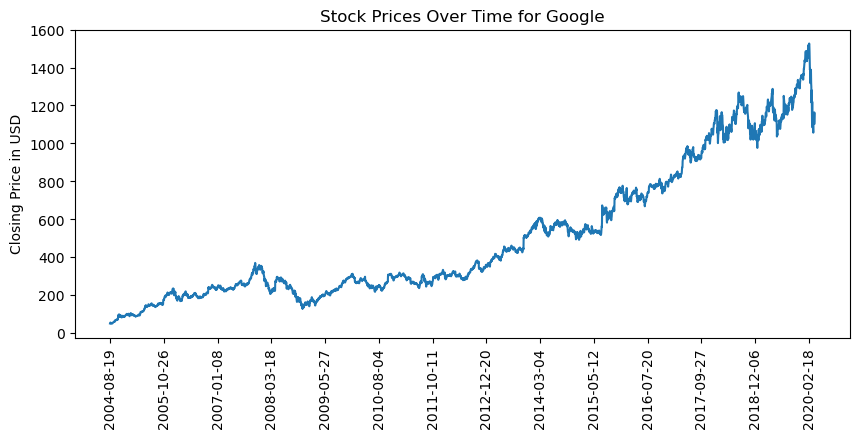

In [50]:
# Plot the closing price of google
plt.figure(figsize=(10, 4))
plt.plot(stock_goog['Date'], stock_goog['Close'])
# plt.xlabel('Date')
plt.xticks(np.arange(0, stock_goog.shape[0], step=300), stock_goog['Date'][0:stock_goog.shape[0]:300], rotation = 90)
plt.ylabel('Closing Price in USD')
plt.title('Stock Prices Over Time for Google')
plt.show()

This transformation standardizes the price data, making it more suitable for use in machine learning models by ensuring consistent scale across the dataset.

In [51]:
scaler = MinMaxScaler(feature_range=(0,1))
stock_goog_scaled = scaler.fit_transform(stock_goog['Close'].values.reshape(-1,1))

The code snippet defines a function create_sequences to transform a time series dataset into sequences suitable for training LSTM models, using a time_step of 60 to create each sequence. After segmenting the scaled stock data into input-output pairs, the input data (X) is reshaped into the required three-dimensional format for LSTM networks. This process is essential for preparing the data for effective time series prediction with neural networks.

In [52]:
# Function to create sequences
def create_sequences(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:i + time_step])
        Y.append(data[i + time_step])
    return np.array(X), np.array(Y)

# Set the time step
time_step = 60  # You can adjust this value

# Create sequences
X, y = create_sequences(stock_goog_scaled, time_step)

# Reshape the data to be [samples, time steps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (3872, 60, 1)
Shape of y: (3872, 1)


## Build a RNN Model

In [53]:
# Build and train RNN Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X, y, batch_size=1, epochs=1)

c:\Users\Kai\anaconda3\envs\stock_env\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3872/3872 ━━━━━━━━━━━━━━━━━━━━ 59s 15ms/step - loss: 0.0013


LSTM Layers:

- The first LSTM layer has 50 units and returns sequences. This means it returns the full sequence to the next layer rather than just the output of the last timestep, maintaining the temporal sequence information which is essential for understanding the context in time series data.

- The second LSTM layer also has 50 units but does not return sequences, meaning it only returns the output of the last timestep. This setup helps the model to condense the information learned from the input sequence into a single output that feeds into the dense layers.

- The "input_shape" parameter in the first LSTM layer specifies the shape of the input (number of timesteps and features per timestep), which is necessary for the model to know the input dimension it is working with.

Dense Layers:

After LSTM layers, there are two Dense (fully connected) layers with 25 and 1 unit respectively. The first dense layer with 25 units is used to interpret the features extracted by the LSTMs, while the final dense layer condenses them into a single scalar output representing the predicted value (e.g., next day's stock price).

Optimizer:

The model uses the Adam optimizer, which is an extension to stochastic gradient descent. Adam is known for its effectiveness in large datasets and high-dimensional spaces, and it adjusts the learning rate dynamically, improving the convergence.

Loss Function:

Mean Squared Error (MSE) is used as the loss function, which is standard for regression problems. MSE calculates the average of the squares of the errors between actual and predicted values, aiming to minimize the difference during training.

Training:

- The model is trained with a batch size of 1, meaning that the model updates weights after every sample. This approach, often called online training, can lead to high variance in the updates, but it's beneficial for adapting quickly to new data.

- Training for only one epoch suggests this is likely a demonstration or a test run. Typically, more epochs would be necessary for the model to learn effectively.

In [54]:
# Make predictions
predictions = model.predict(X)
predictions = scaler.inverse_transform(predictions)

121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


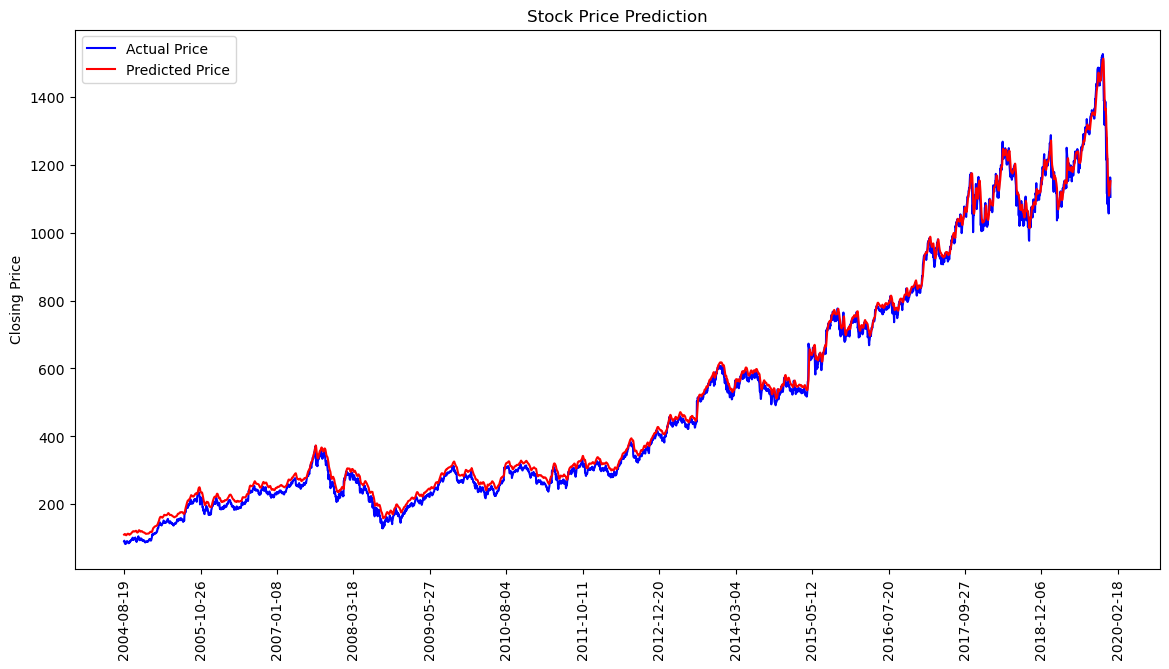

In [55]:
# Plot the predictions
plt.figure(figsize=(14, 7))
plt.plot(stock_goog['Date'][time_step:], stock_goog['Close'][time_step:], label='Actual Price', color='blue')
plt.plot(stock_goog['Date'][time_step:], predictions, label='Predicted Price', color='red')
# plt.xlabel('Date')
plt.xticks(np.arange(0, stock_goog.shape[0], step=300), stock_goog['Date'][0:stock_goog.shape[0]:300], rotation = 90)
plt.ylabel('Closing Price')
plt.title('Stock Price Prediction')
plt.legend()
plt.show()

## Model Augmentation

In [56]:
# Adjusting the model architecture and adding regularization
model2 = Sequential()
model2.add(LSTM(100, return_sequences=True, input_shape=(time_step, 1)))
model2.add(Dropout(0.2))
model2.add(LSTM(100, return_sequences=False))
model2.add(Dropout(0.2))
model2.add(Dense(50))
model2.add(Dense(1))

# Using a different optimizer and adding learning rate scheduler
model2.compile(optimizer='adam', loss='mean_squared_error')

# Training the model with more epochs, batch size and callbacks
model2.fit(X, y, batch_size=32, epochs=10)

Epoch 1/10


c:\Users\Kai\anaconda3\envs\stock_env\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


121/121 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - loss: 0.0171
Epoch 2/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 8.5760e-04
Epoch 3/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 8.0821e-04
Epoch 4/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 6.5624e-04
Epoch 5/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 6.1726e-04
Epoch 6/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 4.8543e-04
Epoch 7/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 5.4301e-04
Epoch 8/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 4.3730e-04
Epoch 9/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 4.5617e-04
Epoch 10/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 4.2799e-04


### Explanation of Changes

- Increased LSTM Units: Increasing the number of units in LSTM layers to 100 to allow the model to learn more complex patterns in the data.

- Dropout: Added dropout layers with a rate of 0.2 after each LSTM layer to prevent overfitting by randomly setting input units to 0 during training.

- Batch Size and Epochs: Increased batch size to 32 for more stable gradient estimates and set to train for 10 epochs to give the model more time to converge.

In [57]:
# Make predictions
predictions2 = model2.predict(X)
predictions2 = scaler.inverse_transform(predictions2)

121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


In [58]:
print(stock_goog['Close'])

0         49.982655
1         53.952770
2         54.495735
3         52.239193
4         52.802086
           ...     
3927    1161.750000
3928    1110.709961
3929    1146.819946
3930    1162.810059
3931    1105.619995
Name: Close, Length: 3932, dtype: float64


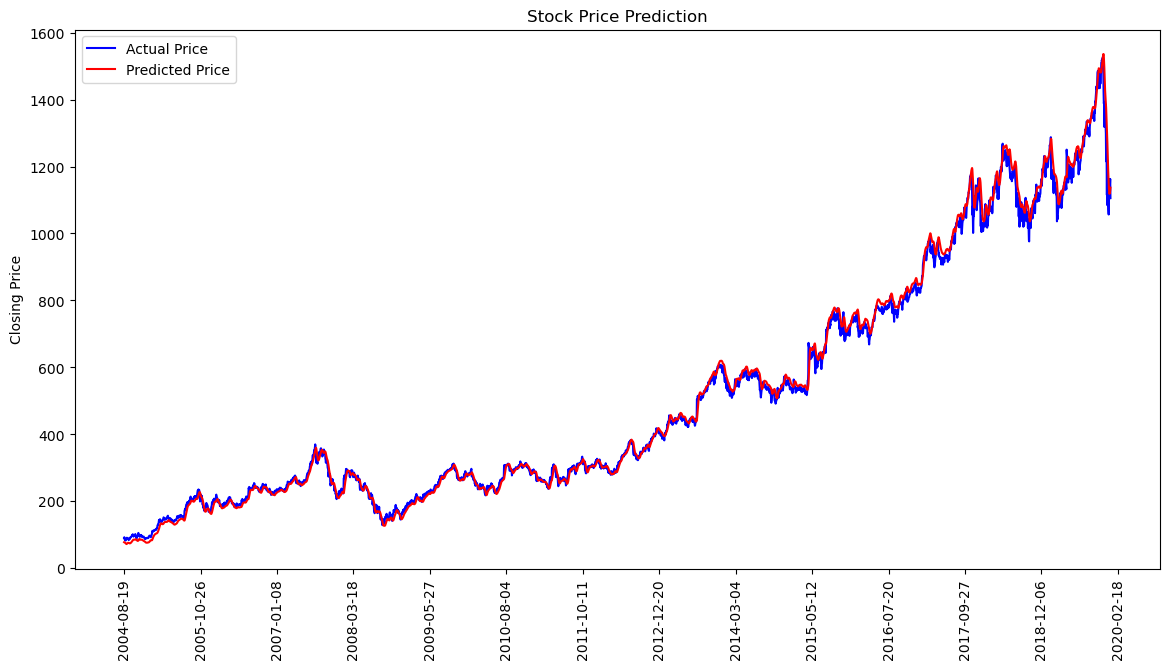

In [59]:
# Plot the predictions
plt.figure(figsize=(14, 7))
plt.plot(stock_goog['Date'][time_step:], stock_goog['Close'][time_step:], label='Actual Price', color='blue')
plt.plot(stock_goog['Date'][time_step:], predictions2, label='Predicted Price', color='red')
# plt.xlabel('Date')
plt.xticks(np.arange(0, stock_goog.shape[0], step=300), stock_goog['Date'][0:stock_goog.shape[0]:300], rotation = 90)
plt.ylabel('Closing Price')
plt.title('Stock Price Prediction')
plt.legend()
plt.show()

## Comparison

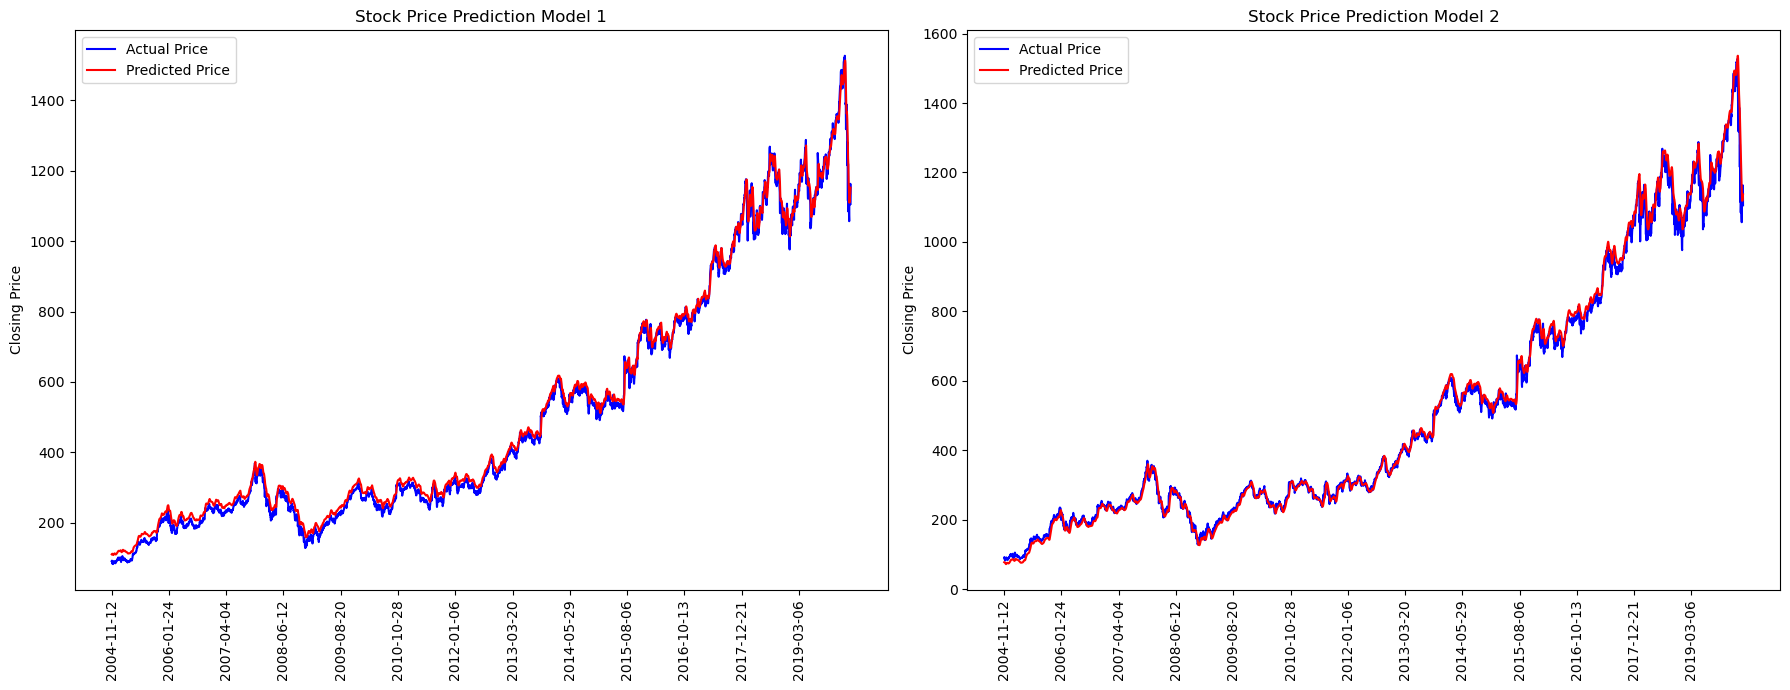

In [60]:
# Assuming 'stock_goog', 'predictions', and 'predictions2' are predefined
time_step = 60  # Adjust time_step if necessary

# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 2, figsize=(18, 7))  # 1 row, 2 columns

# Plotting the actual and predicted prices on the first subplot
axs[0].plot(stock_goog['Date'][time_step:], stock_goog['Close'][time_step:], label='Actual Price', color='blue')
axs[0].plot(stock_goog['Date'][time_step:], predictions, label='Predicted Price', color='red')
axs[0].set_xticks(np.arange(0, stock_goog.shape[0] - time_step, step=300))
axs[0].set_xticklabels(stock_goog['Date'][time_step::300], rotation = 90)
axs[0].set_ylabel('Closing Price')
axs[0].set_title('Stock Price Prediction Model 1')
axs[0].legend()

# Plotting the actual and predicted prices on the second subplot
axs[1].plot(stock_goog['Date'][time_step:], stock_goog['Close'][time_step:], label='Actual Price', color='blue')
axs[1].plot(stock_goog['Date'][time_step:], predictions2, label='Predicted Price', color='red')
axs[1].set_xticks(np.arange(0, stock_goog.shape[0] - time_step, step=300))
axs[1].set_xticklabels(stock_goog['Date'][time_step::300], rotation = 90)
axs[1].set_ylabel('Closing Price')
axs[1].set_title('Stock Price Prediction Model 2')
axs[1].legend()

# Adjust layout
plt.tight_layout()
plt.show()


In [61]:
# Actual stock prices
actual_prices = scaler.inverse_transform(y)

# Calculate MAE
mae_model1 = mean_absolute_error(actual_prices, predictions)
mae_model2 = mean_absolute_error(actual_prices, predictions2)

# Calculate MSE
mse_model1 = mean_squared_error(actual_prices, predictions)
mse_model2 = mean_squared_error(actual_prices, predictions2)

# Calculate RMSE
rmse_model1 = np.sqrt(mse_model1)
rmse_model2 = np.sqrt(mse_model2)

print(f"Model 1 - MAE: {mae_model1}, MSE: {mse_model1}, RMSE: {rmse_model1}")
print(f"Model 2 - MAE: {mae_model2}, MSE: {mse_model2}, RMSE: {rmse_model2}")

Model 1 - MAE: 16.92834106555655, MSE: 418.6105108281628, RMSE: 20.459973382880115
Model 2 - MAE: 14.110932728475776, MSE: 462.6256608005195, RMSE: 21.508734523456265


In [62]:

# Number of days to predict
n_days = 7

# Ensure 'X' is your input data and 'scaler' is your scaler used for normalization

# Get the last window of data and ensure it has the correct shape
last_window = X[-1]  # assuming X is your input data for the model
predictions = []

for _ in range(n_days):
    # Reshape the last window to fit the model's expected input
    last_window_reshaped = last_window.reshape((1, last_window.shape[0], last_window.shape[1]))
    
    # Predict the next day
    next_pred = model2.predict(last_window_reshaped)
    next_pred = scaler.inverse_transform(next_pred)
    
    # Append the prediction to the list
    predictions.append(next_pred[0, 0])
    
    # Update the last window with the new prediction (shift window)
    next_pred_reshaped = next_pred.reshape(1, 1)  # Reshape to match the last_window dimensions
    last_window = np.append(last_window[:, 1:], next_pred_reshaped, axis=1)
    last_window = scaler.transform(last_window)

# Convert predictions to a DataFrame for better visualization
future_dates = pd.date_range(start=df.index[-1], periods=n_days + 1, closed='right')
future_predictions = pd.DataFrame(predictions, index=future_dates, columns=['Predicted Price'])

print(future_predictions)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 60 and the array at index 1 has size 1